## CASE STUDY 003

Aplicando SOM para análise do acumulado de flashes mensais por tipo de solo undersampling

In [1]:
import sys; sys.path.insert(0, "/home/adriano/sthunder")
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sthunder import constants as const
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import os
import shapely.geometry as sgeom
import shapely.wkt as swkt
from descartes import PolygonPatch

import xarray as xr
from minisom import MiniSom

In [2]:
def p70(x): return np.percentile(x, 70)
def p75(x): return np.percentile(x, 75)
def p80(x): return np.percentile(x, 80)
def p85(x): return np.percentile(x, 85)
def p90(x): return np.percentile(x, 90)
def p91(x): return np.percentile(x, 91)
def p92(x): return np.percentile(x, 92)
def p93(x): return np.percentile(x, 93)
def p94(x): return np.percentile(x, 94)
def p95(x): return np.percentile(x, 95)
def p97(x): return np.percentile(x, 97)
def p99(x): return np.percentile(x, 99)

df = pd.read_csv("/glm/city_state.csv")
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', drop=True, inplace=True)
df.head()

,city,uf,total,coords
datetime,,,,
2020-01-01 00:00:00,Abel Figueiredo,PA,0,POINT(-48.5 -5)
2020-01-01 01:00:00,Abel Figueiredo,PA,0,POINT(-48.5 -5)
2020-01-01 02:00:00,Abel Figueiredo,PA,0,POINT(-48.5 -5)
2020-01-01 03:00:00,Abel Figueiredo,PA,0,POINT(-48.5 -5)
2020-01-01 04:00:00,Abel Figueiredo,PA,0,POINT(-48.5 -5)


In [3]:
flashes_df = df.groupby(['coords', pd.Grouper(freq='M')]).agg({
    'total': ['max', 'sum', 'mean', 'std',# p70, p75, p80, 
    p85, p90, p91, p92, p93, p94, p95, 
    p97, p99]
})

flashes_df.head()

# df['geometry'] = gpd.GeoSeries.from_wkt(df['coords'])
# df.drop('coords', inplace=True)

total                                               \
                             max  sum      mean       std  p85  p90  p91  p92   
coords          datetime                                                        
POINT(-35 -6.5) 2020-01-31    28   74  0.099462  1.293237  0.0  0.0  0.0  0.0   
                2020-02-29    12   46  0.066092  0.750021  0.0  0.0  0.0  0.0   
                2020-03-31    27  131  0.176075  1.487469  0.0  0.0  0.0  0.0   
                2020-04-30    19   47  0.065278  0.843804  0.0  0.0  0.0  0.0   
                2020-05-31     8   28  0.037634  0.400111  0.0  0.0  0.0  0.0   

                                                      
                            p93  p94  p95  p97   p99  
coords          datetime                              
POINT(-35 -6.5) 2020-01-31  0.0  0.0  0.0  0.0  1.00  
                2020-02-29  0.0  0.0  0.0  0.0  1.05  
                2020-03-31  0.0  0.0  0.0  0.0  6.00  
                2020-04-30  0.0  0.0  0.0  0.0  1.00  
                2020-05-31  0.0  0.0  0.0  0.0  1.00

In [4]:
flashes_df = flashes_df.reset_index()

columnsdf = ('coords', 'datetime', 'max', 'sum', 'mean', 'std', 'p85', 
             'p90', 'p91', 'p92', 'p93', 'p94', 'p95', 'p97', 'p99')
flashes_df.columns = columnsdf
flashes_df.head()

,coords,datetime,max,sum,mean,std,p85,p90,p91,p92,p93,p94,p95,p97,p99
0,POINT(-35 -6.5),2020-01-31,28,74,0.099462,1.293237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
1,POINT(-35 -6.5),2020-02-29,12,46,0.066092,0.750021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.05
2,POINT(-35 -6.5),2020-03-31,27,131,0.176075,1.487469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00
3,POINT(-35 -6.5),2020-04-30,19,47,0.065278,0.843804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
4,POINT(-35 -6.5),2020-05-31,8,28,0.037634,0.400111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00


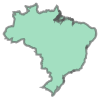

In [5]:
geom_brazil = gpd.read_file(
    "/home/adriano/CAP-395/data/GEO/Vector/SouthAmericaPolygon/South_America.shp"
).query("COUNTRY == 'Brazil'").iloc[0, -1]
geom_brazil

In [6]:
nc = xr.load_dataset("/glm/G05GT1H/GLM_2020_01_hourly_05x05.nc")
glons = nc['lon'].data
glats = nc['lat'].data
gtimes = nc['time'].data
gvars = nc['var'].data
lc = np.load('../land_cover.npy')


clons, clats, lons_idx, lats_idx = [], [], [], []
for i, lat in enumerate(glats):
    for j, lon in enumerate(glons):
        if geom_brazil.contains(sgeom.Point(lon, lat)):
            clats.append(lat)
            clons.append(lon)
            lats_idx.append(i)
            lons_idx.append(j)

clons = np.array(clons)
clats = np.array(clats)
lons_idx = np.array(lons_idx)
lats_idx = np.array(lats_idx)

ref = {}
id = 0
for lat, lon, i, j in zip(clats, clons, lats_idx, lons_idx):
    if str(lat)[-1] == '0':
        lat = int(lat)
    if str(lon)[-1] == '0':
        lon = int(lon)
    
    ref[f'POINT({lon} {lat})'] = lc.T[i][j]

In [7]:
flashes_df['landclass'] = -1

for k, v in ref.items():
    flashes_df.loc[flashes_df.coords == k, "landclass"] = v

flashes_df.head()

,coords,datetime,max,sum,mean,std,p85,p90,p91,p92,p93,p94,p95,p97,p99,landclass
0,POINT(-35 -6.5),2020-01-31,28,74,0.099462,1.293237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,3
1,POINT(-35 -6.5),2020-02-29,12,46,0.066092,0.750021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.05,3
2,POINT(-35 -6.5),2020-03-31,27,131,0.176075,1.487469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.00,3
3,POINT(-35 -6.5),2020-04-30,19,47,0.065278,0.843804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,3
4,POINT(-35 -6.5),2020-05-31,8,28,0.037634,0.400111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,3


In [8]:
flashes_df = pd.concat([
    flashes_df.query("landclass == 1").sample(60, replace=False, random_state=42),
    flashes_df.query("landclass == 2").sample(60, replace=False, random_state=42),
    flashes_df.query("landclass == 3").sample(60, replace=False, random_state=42),
    flashes_df.query("landclass == 4").sample(60, replace=False, random_state=42),
    flashes_df.query("landclass == 5").sample(60, replace=False, random_state=42),
    flashes_df.query("landclass == 6").sample(60, replace=False, random_state=42),
], sort=False)

flashes_df.head()

,coords,datetime,max,sum,mean,std,p85,p90,p91,p92,p93,p94,p95,p97,p99,landclass
14726,POINT(-51.5 -13),2020-03-31,416,2597,3.490591,23.655216,0.0,2.0,3.0,5.00,6.00,7.42,11.00,26.42,75.57,1
32218,POINT(-68.5 -7),2020-11-30,462,3827,5.315278,35.868510,0.0,1.0,1.0,2.00,2.67,6.00,13.05,24.00,208.20,1
12250,POINT(-49.5 -6.5),2020-11-30,693,5665,7.868056,48.201889,0.0,1.0,2.0,3.48,6.00,10.86,36.00,73.72,188.43,1
20067,POINT(-54.5 -29.5),2020-04-30,60,186,0.258333,2.861171,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,6.00,1
7120,POINT(-45.5 -15),2020-05-31,64,185,0.248656,3.478254,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.57,1


In [9]:
flashes_df = flashes_df.reset_index(drop=True)

/home/adriano/sthunder/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/adriano/sthunder/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/adriano/sthunder/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must spe

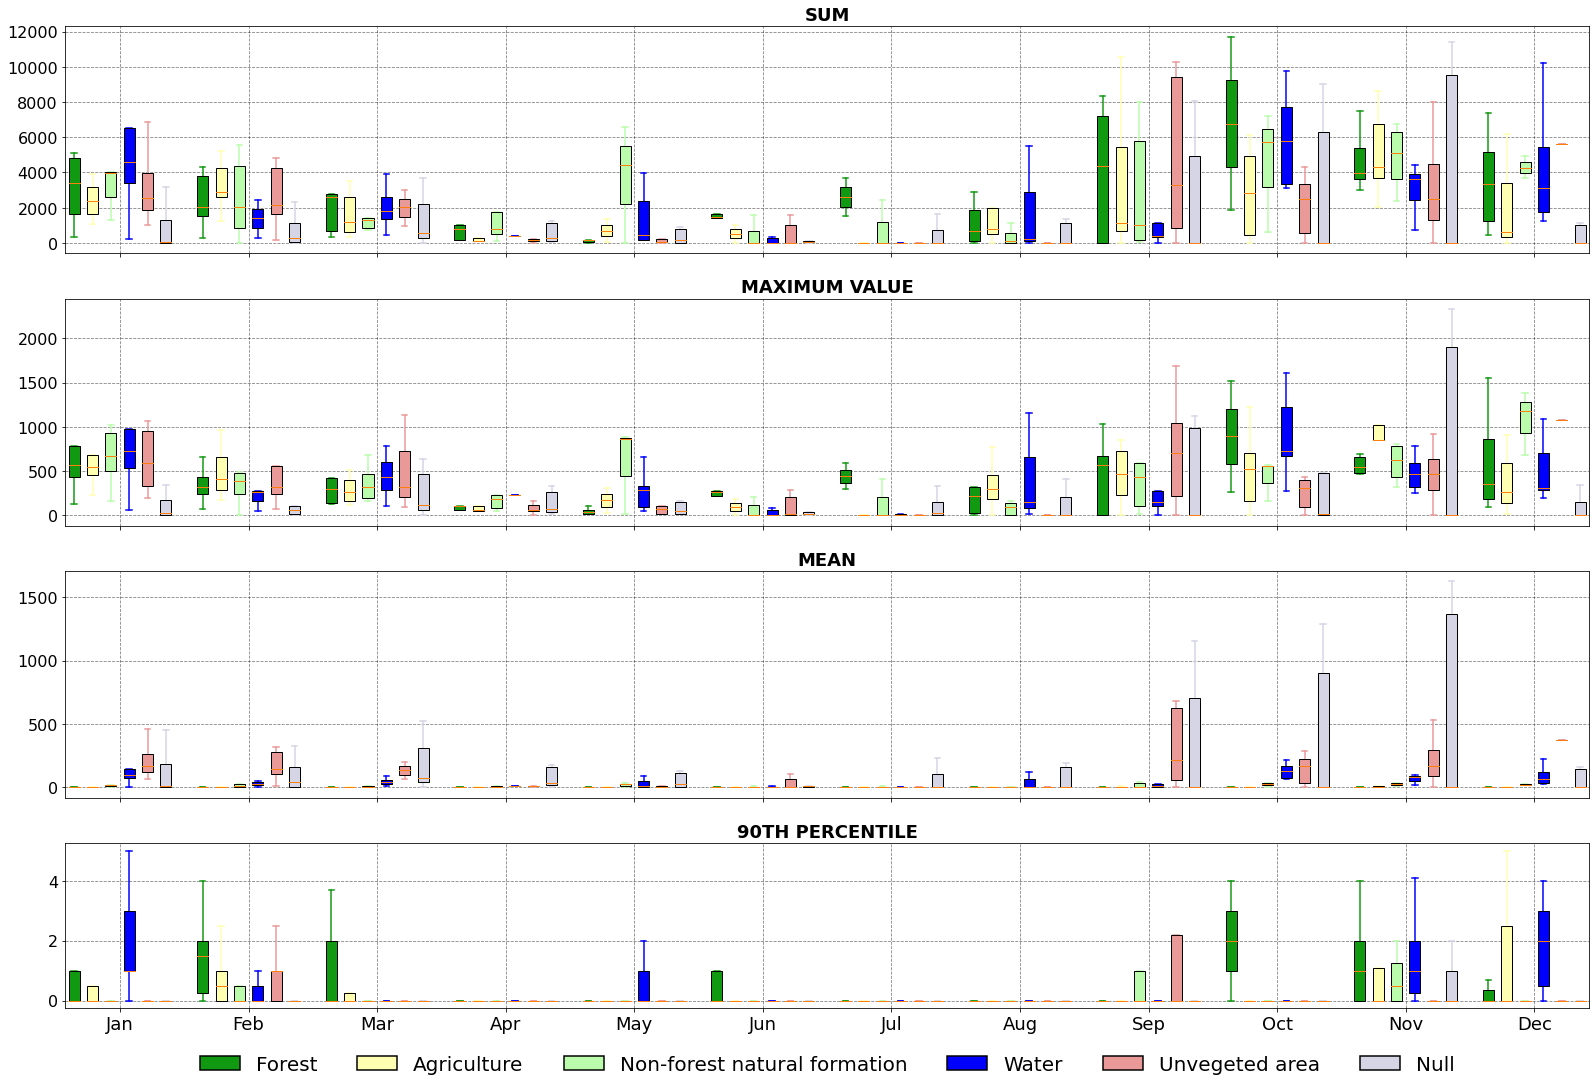

In [10]:
dpi = 100
width = np.round(1366 * 200 / 100)
height = 768*2.5

fig, axes = plt.subplots(4, 1, figsize=(width/dpi, height/dpi),
                         facecolor = 'white', sharex=True)

bp_colors = ['#129912', '#ffffb2', '#bbfcac', '#0000ff', '#ea9999', '#d5d5e5']
# bp_classes = ['Floresta', 'Agropecuário', 'Formação natural', 'Água', 'Área não vegetada', 'Nulo']
bp_classes = ['Forest', 'Agriculture', 'Non-forest natural formation', 'Water', 'Unvegeted area', 'Null']

feats = ['sum', 'max', 'mean', 'p90']
# labels = ['SOMA', 'MÁXIMO', 'TAXA MÉDIA', '90° PERCENTIL']
labels = ['SUM', 'MAXIMUM VALUE', f'MEAN', '90TH PERCENTILE']
npxl = {i: len(np.where(lc == i)[0]) for i in range(1, 7)}
for h, ax in enumerate(axes.flat):
    feat = feats[h]
    dbp = []
    for c in range(1, 7):    
        df_class = flashes_df.query(f"landclass == {c}")
        d = []
        for month in range(1, 13):
            if feat == 'mean':
#                 print('média')
                values = df_class[df_class["datetime"].dt.month == month]['sum'].values/npxl[c]
            else:
                values = df_class[df_class["datetime"].dt.month == month][feat].values
            d.append(values)
        dbp.append(d)

    dbp = np.array(dbp)
    
    pos = 1
    ax.set_title(f"{labels[h]}", fontdict={'size': 18, 'weight': 'bold'})
    ax.grid(ls='--', color='k', alpha=0.5)
    for i, d in enumerate(dbp.T):
        positions = [pos+j for j in range(d.shape[0])]
        bp = ax.boxplot(d, widths=0.6, positions=positions, showfliers=False, patch_artist=True)

        for j in range(d.shape[0]):
    #         print(len(bp['caps']))
            plt.setp(bp['boxes'][j], color='k', facecolor=bp_colors[j])

        j = 0
        for k in range(0, 12, +2):
            plt.setp(bp['whiskers'][k], color=bp_colors[j], lw=1.5)
            plt.setp(bp['whiskers'][k+1], color=bp_colors[j], lw=1.5)

            plt.setp(bp['caps'][k], color=bp_colors[j], lw=1.5)
            plt.setp(bp['caps'][k+1], color=bp_colors[j], lw=1.5)

            j += 1

        pos += d.shape[0]+1 
    ax.tick_params(axis='y', which='major', labelsize=16)

ax.set_xticks([3.5+(7.*i) for i in range(12)])
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 
                    'Sep', 'Oct', 'Nov', 'Dec'], size=18)

divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='7%', pad=0.7)
for i, (color, clas) in enumerate(zip(bp_colors, bp_classes)):
    rect = patches.Rectangle(
        (0, 0), 0, 0, linewidth=1.5, edgecolor='k', facecolor=color, 
        label=clas)
    cax.add_patch(rect)
#     cax.bar([0], [0], facecolor=color, label=clas)

cax.legend(loc='center', ncol=6, fontsize=20, frameon=False)
cax.axis('off')

plt.savefig(f"../statsflashes_landcover_cs3.pdf", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

    

In [11]:
flashes_df

,coords,datetime,max,sum,mean,std,p85,p90,p91,p92,p93,p94,p95,p97,p99,landclass
0,POINT(-51.5 -13),2020-03-31,416,2597,3.490591,23.655216,0.0,2.0,3.0,5.00,6.00,7.42,11.00,26.42,75.57,1
1,POINT(-68.5 -7),2020-11-30,462,3827,5.315278,35.868510,0.0,1.0,1.0,2.00,2.67,6.00,13.05,24.00,208.20,1
2,POINT(-49.5 -6.5),2020-11-30,693,5665,7.868056,48.201889,0.0,1.0,2.0,3.48,6.00,10.86,36.00,73.72,188.43,1
3,POINT(-54.5 -29.5),2020-04-30,60,186,0.258333,2.861171,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,6.00,1
4,POINT(-45.5 -15),2020-05-31,64,185,0.248656,3.478254,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.57,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,POINT(-71.5 -10),2020-07-31,325,1648,2.215054,20.418422,0.0,0.0,0.0,0.00,0.00,0.00,0.00,3.71,70.95,6
356,POINT(-44.5 -2),2020-03-31,112,551,0.740591,5.365125,0.0,0.0,0.0,0.56,1.00,1.00,2.00,4.00,19.14,6
357,POINT(-45 -1.5),2020-05-31,11,24,0.032258,0.445141,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,1.00,6
358,POINT(-72 -10),2020-04-30,334,1232,1.711111,15.442743,0.0,0.0,0.0,0.00,0.00,1.00,2.00,6.00,44.67,6


In [12]:
"%.2f" % SOM.quantization_error(data=data)

NameError: name 'SOM' is not defined

/home/adriano/sthunder/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in long_scalars


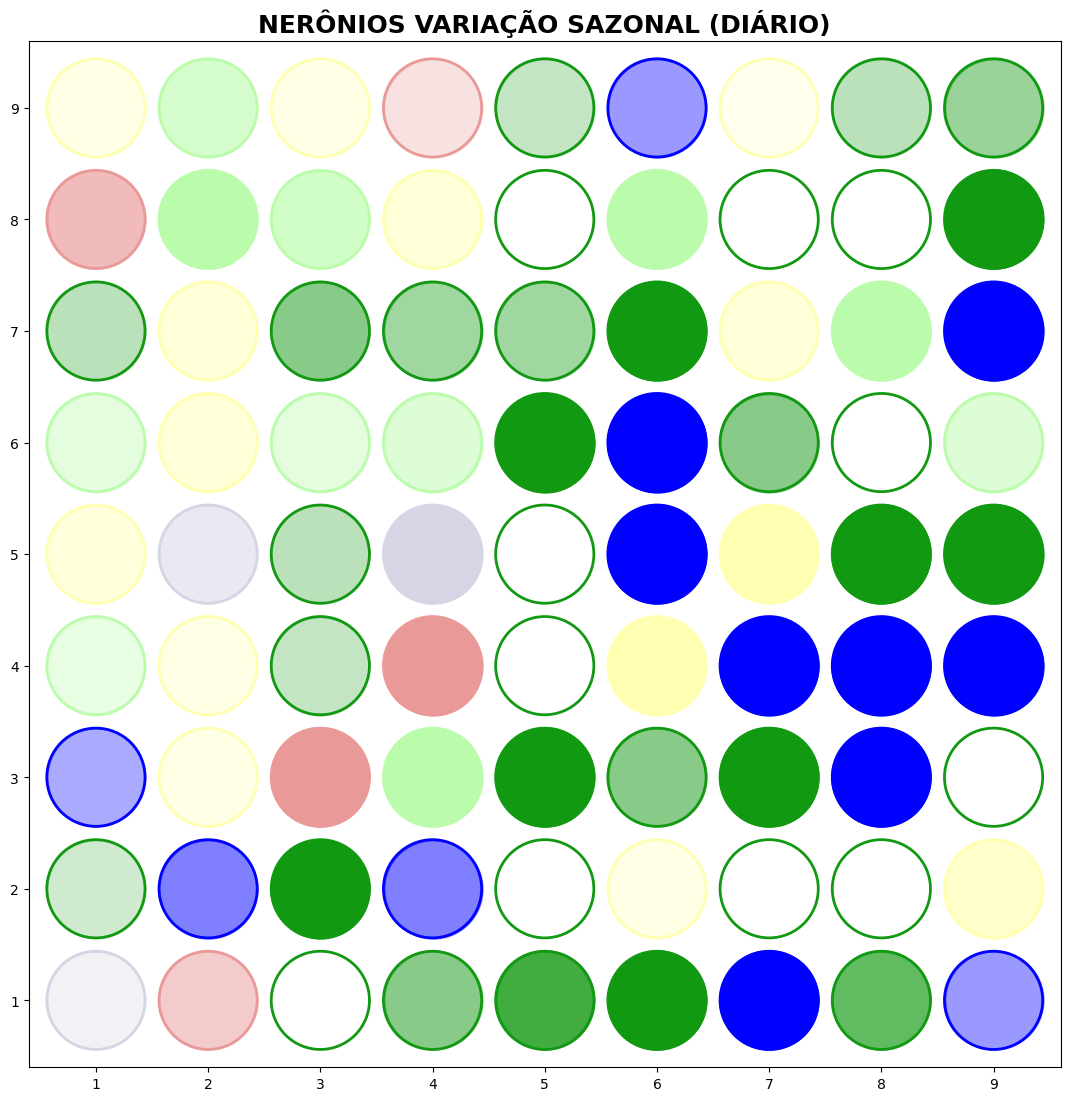

In [13]:
data = flashes_df.iloc[:, 2:-1].values
norm = MinMaxScaler(feature_range=(0, 1))
data = norm.fit_transform(data)
nrow, ncol = 9, 9

SOM = MiniSom(x=nrow, y=ncol, input_len=data.shape[1], sigma=4, learning_rate=.8, 
              neighborhood_function='gaussian',
#               neighborhood_function='bubble',
             topology='hexagonal', activation_distance='manhattan', random_seed=42)
SOM.random_weights_init(data=data)
SOM.train_random(data=data, num_iteration=2000)


# set classes
smaps = [
    np.full((*SOM._weights.shape[:-1],), 0), 
    np.full((*SOM._weights.shape[:-1],), 0),
    np.full((*SOM._weights.shape[:-1],), 0),
    np.full((*SOM._weights.shape[:-1],), 0),
    np.full((*SOM._weights.shape[:-1],), 0),
    np.full((*SOM._weights.shape[:-1],), 0),
]

for i, row in flashes_df.iterrows():
    x, y = SOM.winner(data[i])
    
    smaps[row['landclass']-1][x][y] += 1
    
smaps = np.array(smaps)


# set colormap
color_map = np.full((*SOM._weights.shape[:-1],), 0)
alpha_map = np.full((*SOM._weights.shape[:-1],), 0.)

for i in range(alpha_map.shape[0]):
    for j in range(alpha_map.shape[1]):
        maxv = smaps[:, i, j].max()
        sumv = smaps[:, i, j].sum()
        idxv = np.argmax(smaps[:, i, j])
        
        color_map[i][j] = idxv
        alpha_map[i][j] = maxv/sumv
alpha_map[np.isnan(alpha_map)] = 0


# plot
dpi = 100
width = np.round(1366 * 97.5 / 100)
height = 768*1.77
facecolor = 'white'

fig, ax = plt.subplots(figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor=facecolor)

ax.set_title("NERÔNIOS VARIAÇÃO SAZONAL (DIÁRIO)", fontdict={'size': 18, 'weight': 'bold'})

for i in range(color_map.shape[0]):
    for j in range(color_map.shape[1]):
        ax.scatter([i+.5], [j+.5], color=bp_colors[color_map[i][j]], marker='o', s=5000, alpha=alpha_map[i][j],
            lw=1.5, ec=bp_colors[color_map[i][j]], zorder=1)
        ax.scatter([i+.5], [j+.5], color='none', marker='o', s=5000,
            lw=2, ec=bp_colors[color_map[i][j]], zorder=1)
ax.set_xlim(-0.1, ncol+0.1)
ax.set_ylim(-0.1, nrow+0.1)
ax.set_xticks(np.arange(ncol)+0.5)
ax.set_yticks(np.arange(ncol)+0.5)
ax.set_xticklabels(np.arange(ncol)+1)
ax.set_yticklabels(np.arange(ncol)+1)

plt.savefig(f"../neurons_map_case002-2.png",                                            
                transparent=False, bbox_inches='tight', pad_inches=0.1)

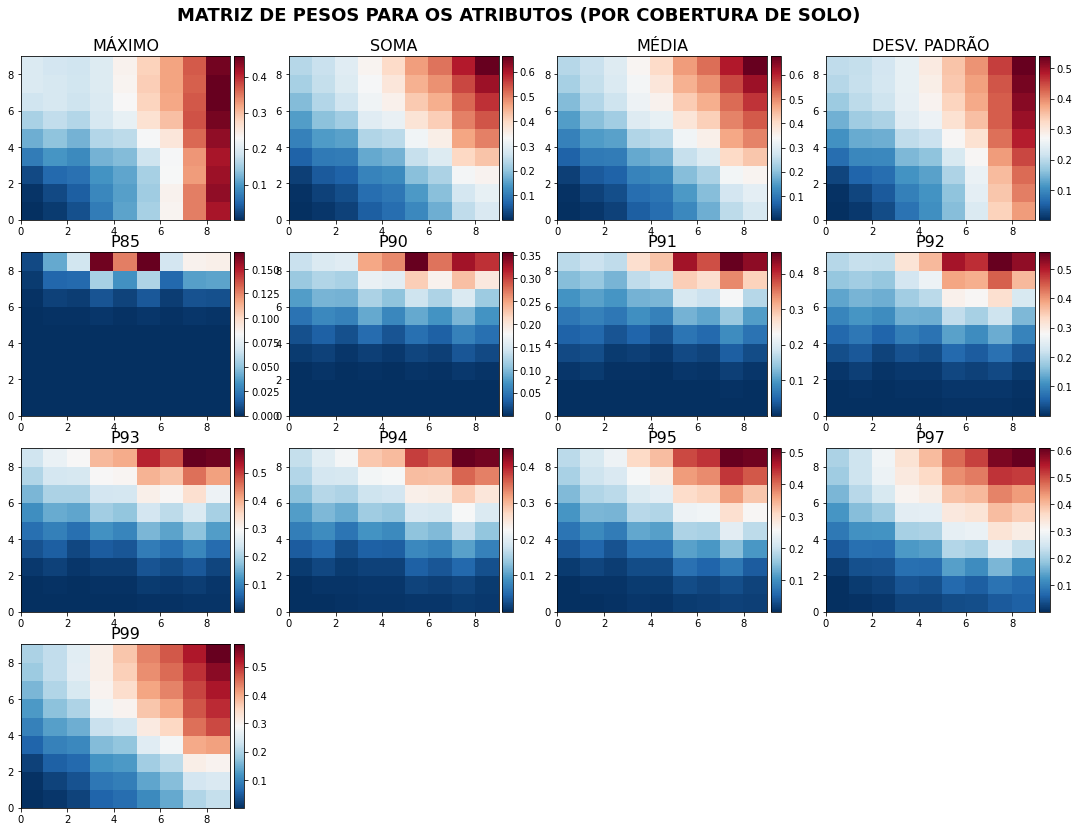

In [14]:
dpi = 100
width = np.round(1366 * 135 / 100)
height = 768*1.8
    
fig, ax = plt.subplots(4, 4, figsize=(width/dpi, height/dpi), facecolor = 'white')
fig.suptitle(f"MATRIZ DE PESOS PARA OS ATRIBUTOS (POR COBERTURA DE SOLO)", 
             fontsize=18, fontweight='bold', y=0.93)

columns = ('MÁXIMO', 'SOMA', 'MÉDIA', 'DESV. PADRÃO',# 'P70', 'P75', 'P80', 
           'P85', 'P90', 'P91', 'P92', 'P93', 'P94', 'P95', 'P97',
          'P99')
for i in range(16):
    row = i//4
    col = i%4
    
    if i < 13:
        divider = make_axes_locatable(ax[row][col])
        cax = divider.append_axes('right', size='5%', pad=0.05)

        ax[row][col].set_title(columns[i], fontdict={'size': 16})
        img = ax[row][col].pcolor(SOM._weights[:, :, i], cmap='RdBu_r')
        fig.colorbar(img, cax=cax, orientation='vertical')
    else:
        ax[row][col].axis('off')
    
plt.savefig(f"../weights_uf_hourly_nn_stations.png", 
                transparent=False, bbox_inches='tight', pad_inches=0.1)

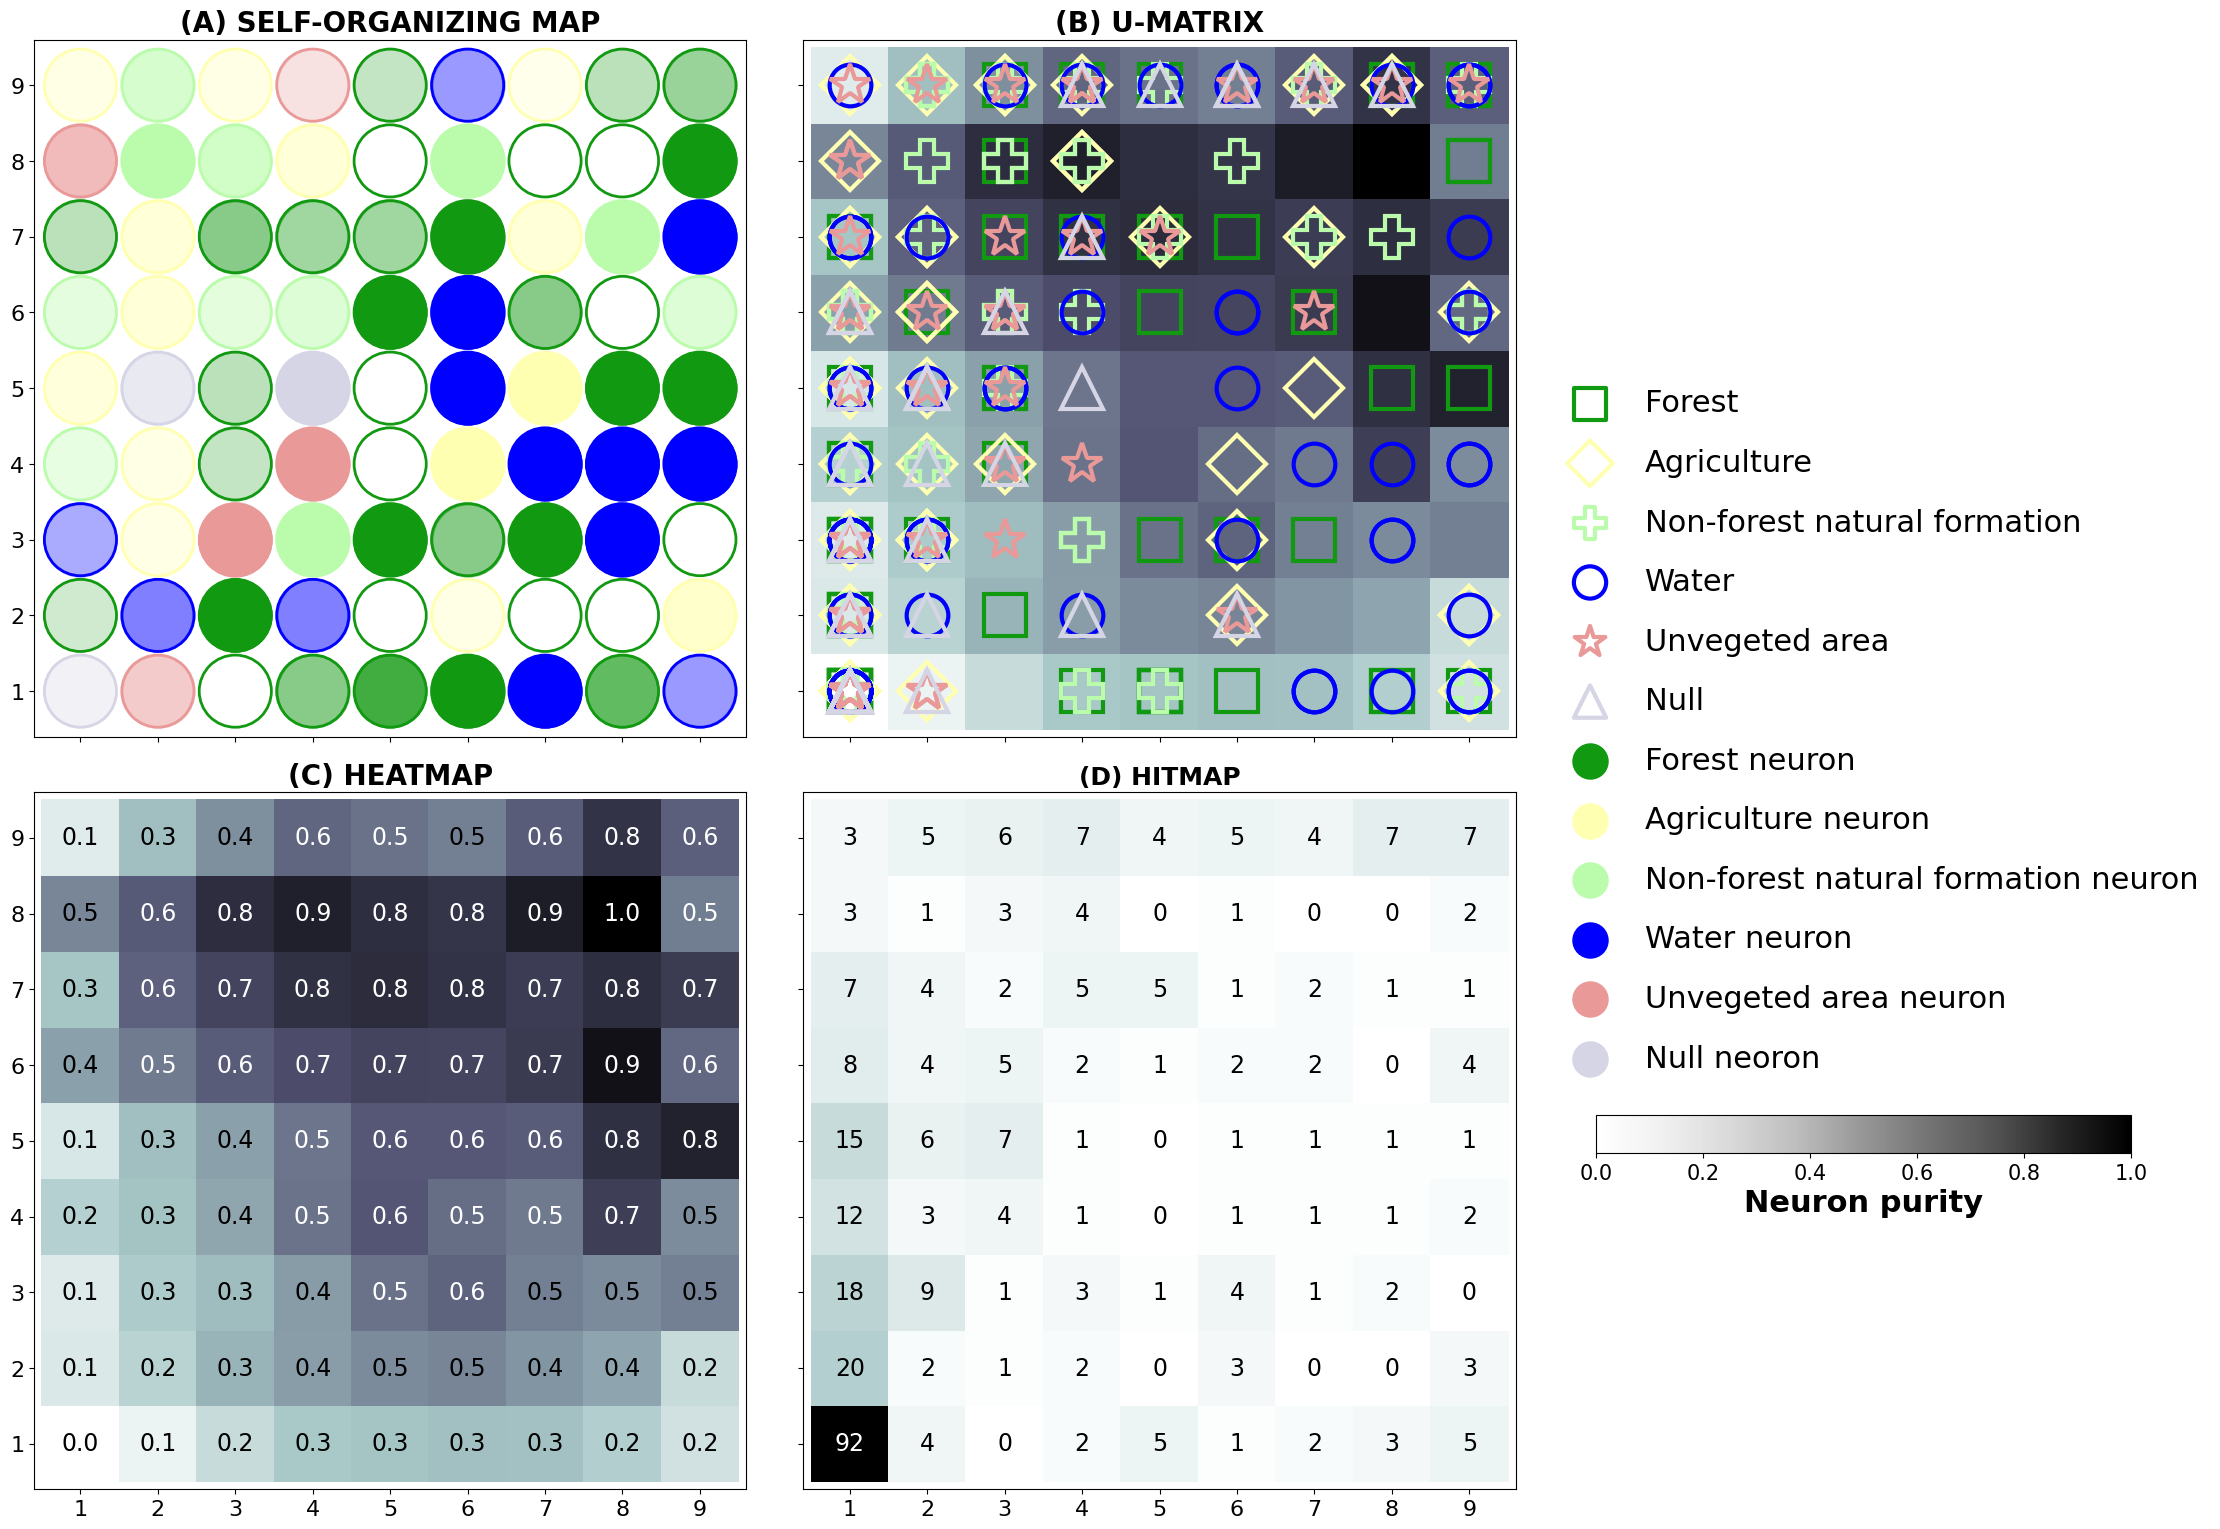

In [15]:
dpi = 100
width = np.round(1366 * 140 / 100)
height = 768*2.5

fig, ax = plt.subplots(2, 2, figsize=(width/dpi, height/dpi), 
                       dpi=dpi, facecolor='w', sharex=True, sharey=True)


# CREATE SELF-ORGANIZING MAP PLOT
ax[0][0].set_title('(A) SELF-ORGANIZING MAP', fontdict={'size': 20, 'fontweight': 'bold'})
for i in range(color_map.shape[0]):
    for j in range(color_map.shape[1]):
        ax[0][0].scatter([i+.5], [j+.5], color=bp_colors[color_map[i][j]], marker='o', s=2700, alpha=alpha_map[i][j],
            lw=1.5, ec=bp_colors[color_map[i][j]], zorder=1)
        ax[0][0].scatter([i+.5], [j+.5], color='none', marker='o', s=2700,
            lw=2, ec=bp_colors[color_map[i][j]], zorder=1)
ax[0][0].set_xlim(-0.1, ncol+0.1)
ax[0][0].set_ylim(-0.1, nrow+0.1)
ax[0][0].set_xticks(np.arange(ncol)+0.5)
ax[0][0].set_yticks(np.arange(ncol)+0.5)
ax[0][0].set_xticklabels(np.arange(ncol)+1)
ax[0][0].set_yticklabels(np.arange(ncol)+1)
ax[0][0].tick_params(axis='both', labelsize=16)


# CREATE U-MATRIX PLOT
markers = {1: 's', 2: 'D', 3: 'P', 4: 'o', 5: '*', 6: '^'}
ax[0][1].pcolor(SOM.distance_map().T, cmap='bone_r')
for i, d in enumerate(data):
    x, y = SOM.winner(d)
    ax[0][1].plot(x+0.5, y+0.5, markerfacecolor='None', markersize=30, 
               markeredgewidth=3, marker=markers[flashes_df.iloc[i, -1]], 
               color=bp_colors[flashes_df.iloc[i, -1]-1])
    
ax[0][1].set_title('(B) U-MATRIX', fontdict={'size': 20, 'fontweight': 'bold'})
ax[0][1].set_xticks(np.arange(ncol)+0.5)
ax[0][1].set_yticks(np.arange(nrow)+0.5)
ax[0][1].set_xticklabels(np.arange(ncol)+1)
ax[0][1].set_yticklabels(np.arange(nrow)+1)
ax[0][1].tick_params(axis='both', labelsize=16)


# CREATE HEATMAP PLOT
dm = SOM.distance_map().T
ax[1][0].pcolor(dm, cmap='bone_r')
for i in range(dm.shape[0]):
    for j in range(dm.shape[1]):
        color = 'w' if dm[i][j] > dm.max()/2 else 'k'
        ax[1][0].text(j+0.5, i+0.5, '%.1f'%dm[i][j], ha='center', va='center', color=color, fontsize=17)
ax[1][0].set_title('(C) HEATMAP', fontdict={'size': 20, 'fontweight': 'bold'})
ax[1][0].set_xticks(np.arange(ncol)+0.5)
ax[1][0].set_yticks(np.arange(nrow)+0.5)
ax[1][0].set_xticklabels(np.arange(ncol)+1)
ax[1][0].set_yticklabels(np.arange(nrow)+1)
ax[1][0].tick_params(axis='both', labelsize=16)


# CREATE HITMAP PLOT
freq = SOM.activation_response(data).astype(int)
ax[1][1].pcolor(freq.T, cmap='bone_r') 
for (i, j), z in np.ndenumerate(freq.T):
    color = 'w' if z > freq.T.max()/2 else 'k'
    ax[1][1].text(j+0.5, i+0.5, z, ha='center', va='center', color=color, fontsize=17)
# ax[1].colorbar(cmap)
ax[1][1].set_title('(D) HITMAP', fontdict={'size': 18, 'fontweight': 'bold'})
ax[1][1].set_xticks(np.arange(ncol)+0.5)
ax[1][1].set_yticks(np.arange(nrow)+0.5)
ax[1][1].set_xticklabels(np.arange(ncol)+1)
ax[1][1].set_yticklabels(np.arange(nrow)+1)
ax[1][1].tick_params(axis='both', labelsize=16)

plt.subplots_adjust(left=None, bottom=None, 
                    right=None, top=None, 
                    wspace=0.08, hspace=0.08)


cax = fig.add_axes([1.08, 0.27, 0.02, 0.5])
cax.scatter([], [], ec=bp_colors[0], s=540, marker='s', lw=3, color='none', label='Forest')
cax.scatter([], [], ec=bp_colors[1], s=540, marker='D', lw=3, color='none', label='Agriculture')
cax.scatter([], [], ec=bp_colors[2], s=540, marker='P', lw=3, color='none', label='Non-forest natural formation')
cax.scatter([], [], ec=bp_colors[3], s=540, marker='o', lw=3, color='none', label='Water')
cax.scatter([], [], ec=bp_colors[4], s=540, marker='*', lw=3, color='none', label='Unvegeted area')
cax.scatter([], [], ec=bp_colors[5], s=540, marker='^', lw=3, color='none', label='Null')
# cax.scatter([], [], color='red', s=340, marker='o', lw=1.5, ec='red', label='Atividade')
# cax.scatter([], [], color='blue', s=340, marker='o', lw=1.5, ec='blue', label='Inatividade')

cax.scatter([], [], ec=bp_colors[0], s=540, marker='o', lw=3, color=bp_colors[0], label='Forest neuron')
cax.scatter([], [], ec=bp_colors[1], s=540, marker='o', lw=3, color=bp_colors[1], label='Agriculture neuron')
cax.scatter([], [], ec=bp_colors[2], s=540, marker='o', lw=3, color=bp_colors[2], label='Non-forest natural formation neuron')
cax.scatter([], [], ec=bp_colors[3], s=540, marker='o', lw=3, color=bp_colors[3], label='Water neuron')
cax.scatter([], [], ec=bp_colors[4], s=540, marker='o', lw=3, color=bp_colors[4], label='Unvegeted area neuron')
cax.scatter([], [], ec=bp_colors[5], s=540, marker='o', lw=3, color=bp_colors[5], label='Null neoron')
# mx, my = np.meshgrid(np.linspace(0, 1, 20), np.linspace(0, 1, 20))
cax.legend(loc='center', ncol=1, labelspacing=1, fontsize=22, frameon=False)
cax.axis('off')

cax2 = fig.add_axes([.942, 0.3, 0.28, 0.02])
img = cax2.pcolor([[]], cmap='Greys', vmin=0, vmax=1)
cbar = fig.colorbar(img, cax=cax2, orientation='horizontal')
cbar.ax.set_xlabel('Neuron purity', rotation=0, fontsize=22, fontweight='bold')
# cbar.ax.get_xaxis().labelpad = -80
cbar.ax.tick_params(labelsize=15)


plt.savefig(f"../maps_landcover_cs03.png",                                            
                transparent=False, bbox_inches='tight', pad_inches=0.1)

In [47]:
color, label

('#d5d5e5', 'Null')

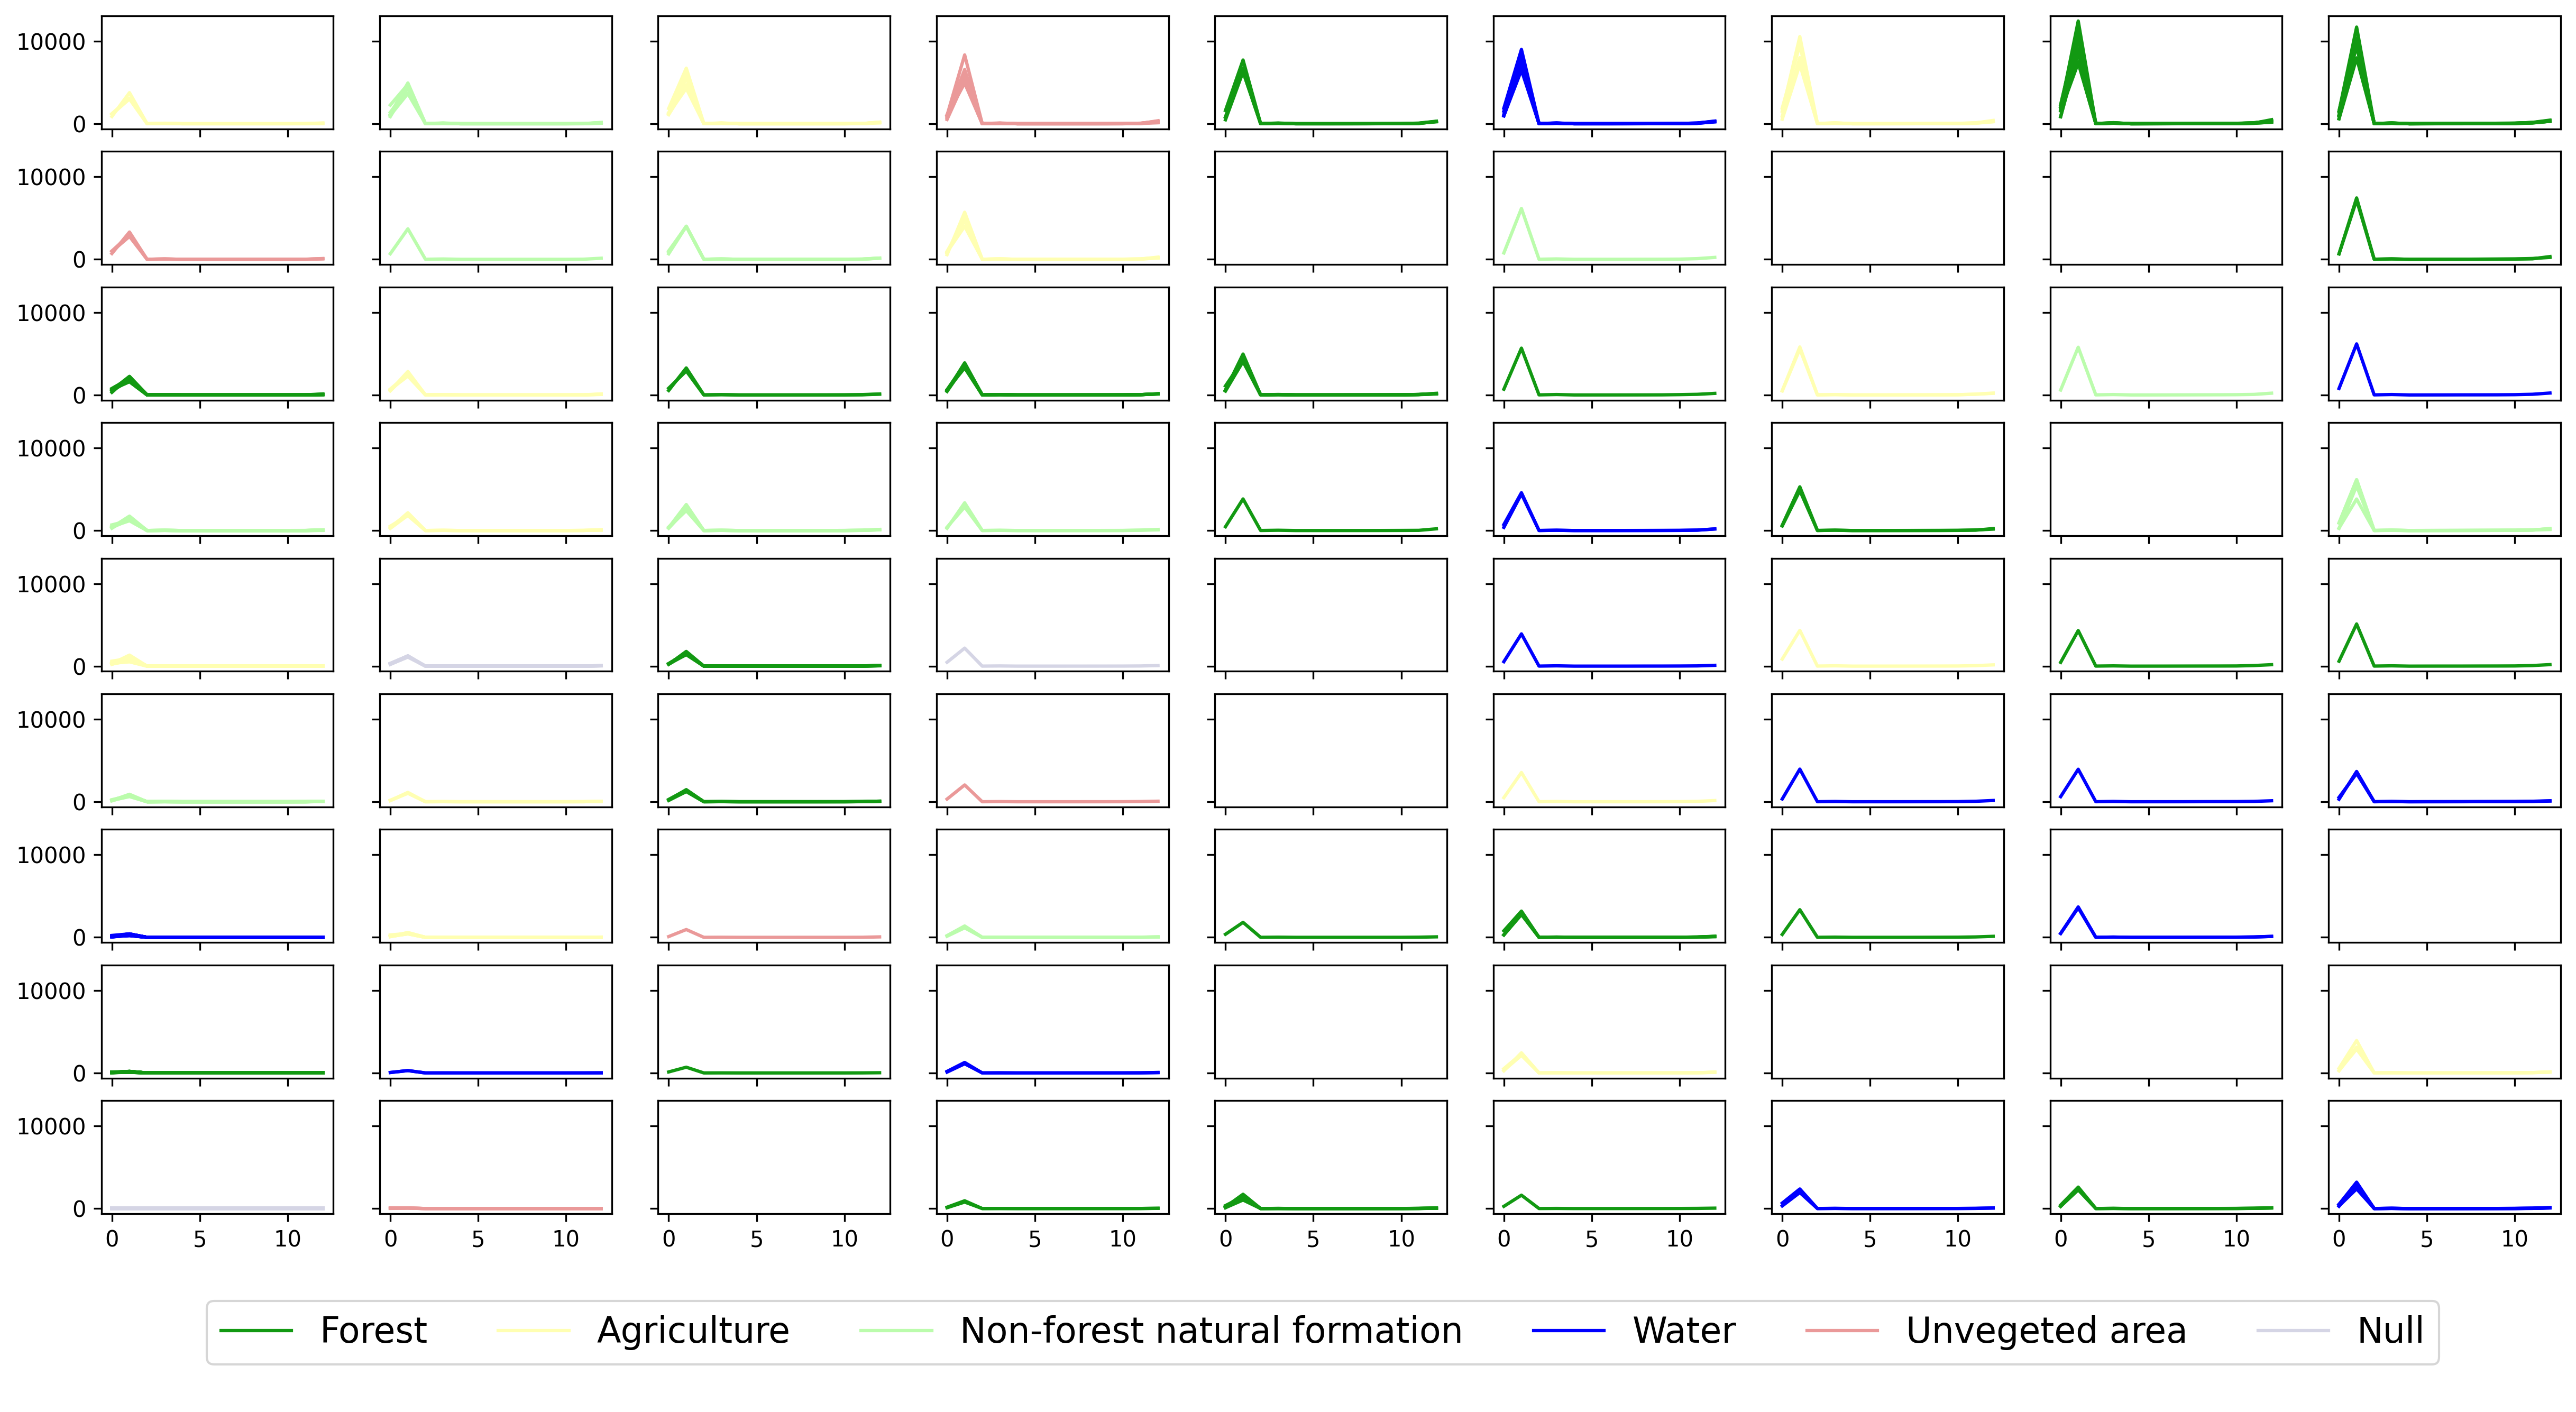

In [52]:
fig, ax = plt.subplots(9, 9, figsize=(20, 10), sharex=True, sharey=True, facecolor='w', dpi=300)

for i, (_, row) in enumerate(flashes_df.iloc[:, 2:-1].iterrows()):
    v = data[i]
    x, y = SOM.winner(v)
    ax[(ncol-1)-y][x].plot(row.values, color=bp_colors[color_map[x][y]])

cax = fig.add_axes([.12, 0.01, 0.78, 0.08])
for color, label in zip(bp_colors, bp_classes):
    cax.plot([], color=color, label=label)
    
cax.legend(loc='center', fontsize=16, ncol=7)
cax.axis('off')

plt.savefig(f"../series_landcover.png", dpi=300,
                transparent=False, bbox_inches='tight', pad_inches=0.1)